### Thickness budget in temperature space

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt
import datetime
#import cftime

In [15]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
averaging = '5daily'
filename = '19000101.ocean_'+averaging+'_native_*.nc'
# filename_snap = '19000101.ocean_'+averaging+'_snap_*.nc'
filename_grid = '19000101.ocean_static.nc'
ds = xr.open_mfdataset(rootdir+filename, combine='by_coords')
# ds = xr.open_dataset(rootdir+filename)
# ds_snap = xr.open_mfdataset(rootdir+filename_snap, combine='by_coords')
grid = xr.open_dataset(rootdir+filename_grid)

cp = 3992
rho0 = 1035

In [16]:
# Load initial conditions, snapshop
filename_ic = 'MOM_IC.nc'
ds_ic = xr.open_dataset(rootdir+filename_ic)
terms = ['Temp','Salt','h']
ds_ic
ds_ic = ds_ic[terms].rename({'Temp':'temp','Salt':'salt','h':'thkcello',
                            'Time':'time','Layer':'zl','lath':'yh','lonh':'xh'}).squeeze()
time_new = xr.cftime_range(start='1900',end='1900',calendar='noleap')
ds_ic = ds_ic.assign_coords({'time':time_new})
ds_snap = xr.concat([ds_ic,ds_snap],dim='time')

NameError: name 'ds_snap' is not defined

In [17]:
# Budget terms
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
h_terms = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
           'boundary_forcing_h_tendency','internal_heat_h_tendency']

In [18]:
# Calculate material derivative and diffusive terms
# HEAT
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

In [10]:
def calc_refine(da,refineby,variable_type,vertc='zl'):
    nk = len(da[vertc])
    # Set vertical coordinate to layer index
    da=da.assign_coords({vertc:np.linspace(1,nk,nk)})
    # Assign a k-value for the interfaces
    k_i = np.linspace(0.5,nk+0.5,nk+1)
    # Develop the super grid, based on the interfaces
    k_i_target = np.linspace(0.5,nk+0.5,nk*refineby+1)
    # Get the value of the layers on the super grid
    k_l_target = 0.5*(k_i_target[1:]+k_i_target[:-1])
    
    # Refine the grid
    if variable_type == 'intensive':
        da_refined = da.interp({vertc:k_l_target},method='linear',kwargs={'fill_value':'extrapolate'})
    if variable_type == 'extensive':
        da_refined = xr.zeros_like(da.interp({vertc:k_l_target}))
        for k in range(nk):
            index = np.arange(k*refineby,(k+1)*refineby)
            vertc_ones = xr.DataArray(np.ones(shape=(refineby)),dims=[vertc],coords={vertc:k_l_target[index]})
            chunk = (da.isel({vertc:k})/refineby)*vertc_ones
            # Input array must have same dimensional order as indexed array
            ### THERE MUST BE A MORE EFFICIENT WAY TO DO THIS ###
            if len(da.dims)==1:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk
            elif len(da.dims)==2:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1])
            elif len(da.dims)==3:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2])
            elif len(da.dims)==4:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2],list(da.dims)[3])
    return da_refined

In [11]:
# Time-mean : for evaluating dia-boundary transport and integrated process tendencies
l = ds['temp'] # Time-mean volume-defining tracer
l_name = l.name+'_bin' # Naming of binning variable as will be defined by xhistogram
dl = dheat/cp # Sum of diffusive tendencies for volume-defining tracer
c = xr.ones_like(ds['thkcello']) # Time-mean of budget tracer
h = ds['thkcello']

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
l_snap = ds_snap['temp'] # Snapshots of volume-defining tracer
c_snap = xr.ones_like(ds_snap['thkcello']) # Snapshots of budget tracer
h_snap = ds_snap['thkcello'] # Snapshots of layer thickness (for tracer content calculation)

# Grid dimensions
area = grid.areacello # Grid dimensions

# Time-mean tendencies of budget tracer due to different processes
f_c = ds['boundary_forcing_h_tendency'] # Boundary forcing

refine = False
refineby = 0

In [9]:
# Refine vertical grid
if refine:
    l = calc_refine(l, refineby=refineby, variable_type='intensive')
    dl = calc_refine(dl, refineby=refineby, variable_type='extensive')
    c = calc_refine(c, refineby=refineby, variable_type='intensive')
    l_snap = calc_refine(l_snap, refineby=refineby, variable_type='intensive')
    c_snap = calc_refine(c_snap, refineby=refineby, variable_type='intensive')
    h_snap = calc_refine(h_snap, refineby=refineby, variable_type='extensive')

    f_c = calc_refine(f_c, refineby=refineby, variable_type='extensive')

In [10]:
# Binning variables
delta_l = 0.5
delta_l_E = 0.25
l_i_vals = np.arange(-4,36,delta_l)
l_i_vals_E = np.arange(-4,36,delta_l_E)

# Calculation of budget tracer content tendency, derived from snapshots
C_mean = wmt.calc_P(rho0*c*h,l,l_i_vals,area) # Binning
C = wmt.calc_P(rho0*c_snap*h_snap,l_snap,l_i_vals,area) # Binning at snapshots
dCdt = C.diff('time')/(C.time.diff('time').astype('float')*1E-9)

# dCdt = dCdt.isel(time=t)
# dCdt_alt = C.differentiate('time').isel(time=t) # Finite difference in time
dCdt = dCdt.rename({l_snap.name+'_bin':l_name}) # Rename dimension for consistency
# dCdt_alt = dCdt_alt.rename({l_snap.name+'_bin':l_name})
# Calculation of E : budget tracer tendency due to dia-boundary mass transport 
E_c = wmt.calc_E(c,l,dl,l_i_vals_E,area,plot=False)#.isel(time=t)
E_c = E_c.rename({l_name:l_name+'_E'})
# Calculation of P^n : volume integrated budget tracer tendencies
F_c = wmt.calc_P(rho0*f_c,l,l_i_vals,area)#.isel(time=t)

dCdt = dCdt.assign_coords({'time':E_c.time})

# Residual
residual = dCdt-E_c-F_c

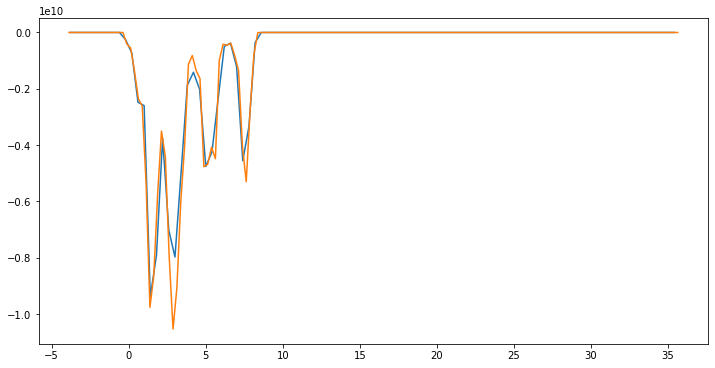

In [11]:
t=1
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
ax1.plot(dCdt[l_name],dCdt.isel(time=t))
ax1.plot(E_c[l_name+'_E'],E_c.isel(time=t))

NameError: name 'residual' is not defined

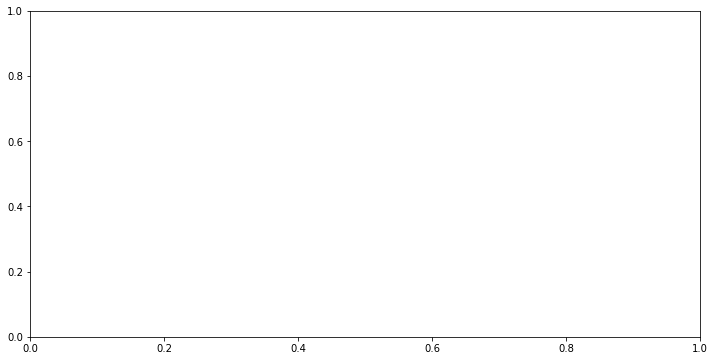

In [12]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
lw = 0.1
tt = 1
for t in range(tt,31):
#     ax1.plot(dCdt[l_name],dCdt.isel(time=t),label='dCdt',color='tab:blue',linewidth=lw)
#     ax1.plot(E_c[l_name],E_c.isel(time=t),label='E_c',color='tab:red',linewidth=lw)
#     ax1.plot(F_c[l_name],F_c.isel(time=t),label='F_c',color='tab:orange',linewidth=lw)
    ax1.plot(residual[l_name],residual.isel(time=t),linestyle='-',label='residual',color='k',linewidth=lw)
# ax1.plot(dCdt[l_name],dCdt.mean('time'),label='dCdt',color='tab:blue')
# ax1.plot(E_c[l_name],E_c.mean('time'),label='E_c',color='tab:red')
# ax1.plot(F_c[l_name],F_c.mean('time'),label='F_c',color='tab:orange')
ax1.plot(residual[l_name],residual.mean('time'),linestyle='-',label='residual',color='k')
# ax1.legend()
print(np.sqrt(np.mean(residual.isel(time=t)**2)))

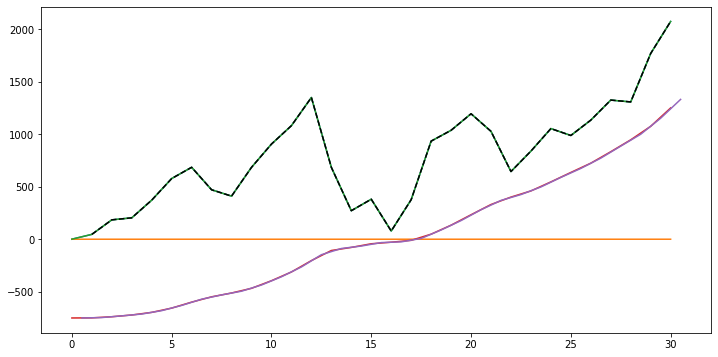

In [10]:
# Total volume balance through time
ds_total=(ds.astype('float64')*grid['areacello']).sum(['xh','yh','zl'])
ds_total_timemean=ds_total.mean('time')
ds_snap_total=(ds_snap.astype('float64')*grid['areacello']).sum(['xh','yh','zl'])
ds_snap_total_timemean=ds_snap_total.mean('time')
dhdt_from_snap = ds_snap_total['thkcello'].diff('time')/86400
days=range(len(ds_total['time']))
days_snap=np.arange(len(ds_snap_total['time']))-0.5
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(days,ds_total['dhdt'], label='dhdt')
ax.plot(days,ds_total['dynamics_h_tendency'])
ax.plot(days,ds_total['boundary_forcing_h_tendency'])
ax.plot(days,(ds_total['thkcello']-ds_total_timemean['thkcello'])*1E-6)
ax.plot(days_snap[1:],(ds_snap_total['thkcello']-ds_total_timemean['thkcello'])[1:]*1E-6)
ax.plot(days[1:],dhdt_from_snap[1:],'k--')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/pyth

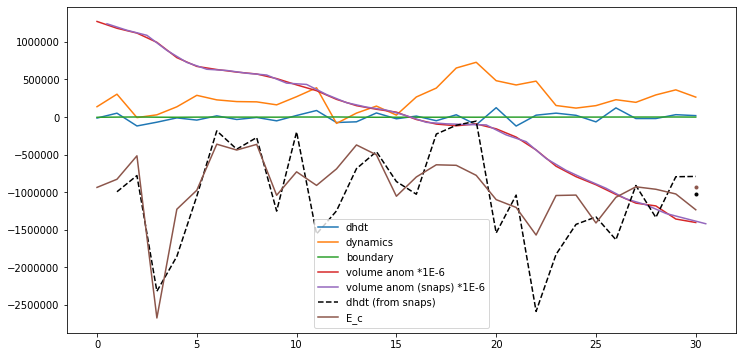

In [11]:
# Now split the volume along some temperature contour and do the same thing
c = 4
ds_total=(ds.astype('float64')*grid['areacello']).where(ds['temp']>c).sum(['xh','yh','zl'])
ds_total_timemean=ds_total.mean('time')
ds_snap_total=(ds_snap.astype('float64')*grid['areacello']).where(ds_snap['temp']>c).sum(['xh','yh','zl'])
ds_snap_total_timemean=ds_snap_total.mean('time')
dhdt_from_snap = ds_snap_total['thkcello'].diff('time')/86400
days=range(len(ds_total['time']))
days_snap=np.arange(len(ds_snap_total['time']))-0.5
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(days,ds_total['dhdt'],label='dhdt')
ax.plot(days,ds_total['dynamics_h_tendency'],label='dynamics')
ax.plot(days,ds_total['boundary_forcing_h_tendency'],label='boundary')
ax.plot(days,(ds_total['thkcello']-ds_total_timemean['thkcello'])*1E-6,label='volume anom *1E-6')
ax.plot(days_snap[1:],(ds_snap_total['thkcello']-ds_total_timemean['thkcello'])[1:]*1E-6,label='volume anom (snaps) *1E-6')
ax.plot(days[1:],dhdt_from_snap[1:],'k--',label='dhdt (from snaps)')

# Calculate E_c around at this contour
dc = 0.25
layer = (ds['temp']>c-dc/2) & (ds['temp']<c+dc/2)
E_c = (dheat*grid['areacello']/cp).where(layer).sum(['xh','yh','zl'])/dc
ax.plot(days,E_c/rho0,label='E_c',color='tab:brown')

ax.legend()

ax.plot(days[-1],dhdt_from_snap[1:].mean('time').values,'k.')
ax.plot(days[-1],(E_c/rho0)[1:].mean('time').values,'.',color='tab:brown')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


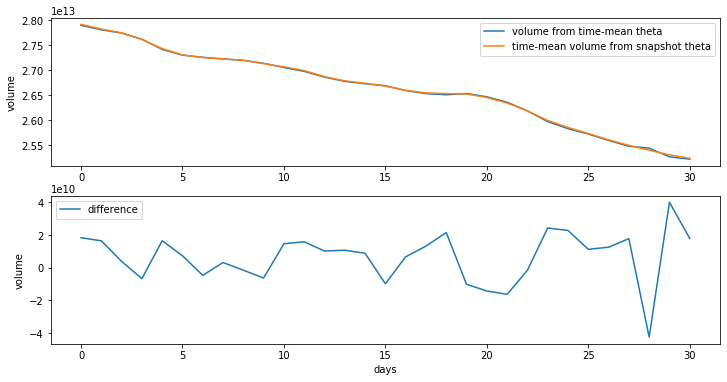

In [9]:
# How well does the time mean of the volume derived from snapshots match that of the volume from the timemean
c = 4
ds_total=(ds.astype('float64')*grid['areacello']).where(ds['temp']>c).sum(['xh','yh','zl'])
ds_snap_total=(ds_snap.astype('float64')*grid['areacello']).where(ds_snap['temp']>c).sum(['xh','yh','zl'])
days=np.arange(len(ds_total['time']))
days_snap=np.arange(len(ds_snap_total['time']))-0.5

fig,(ax,ax1)=plt.subplots(figsize=(12,6), nrows=2)
ax.plot(days,ds_total['thkcello'],label='volume from time-mean theta')
# ax.plot(days_snap,(ds_snap_total['thkcello']),label='volume (from snaps)')
h_snap_mean = 0.5*(ds_snap_total['thkcello'].values[1:]+ds_snap_total['thkcello'].values[:-1])
days_snap_mean = 0.5*(days_snap[1:]+days_snap[:-1])
ax.plot(days_snap_mean,h_snap_mean,label='time-mean volume from snapshot theta')
ax.set_ylabel('volume')
ax.legend()

# fig,ax=plt.subplots(figsize=(12,6))
ax1.plot(days,h_snap_mean-ds_total['thkcello'], label='difference')
ax1.set_xlabel('days')
ax1.set_ylabel('volume')
ax1.legend()

#### Timestep

In [ ]:
t=23
# Binning variables
delta_l = 0.5
l_i_vals = np.arange(-4,36,delta_l)

# Calculation of budget tracer content tendency
dCdt = wmt.calc_P(rho0*c*ds['dhdt'],l,l_i_vals,area).isel(time=t) # Binning at snapshots
# Calculation of E : budget tracer tendency due to dia-boundary mass transport 
E_c = wmt.calc_E(c,l,dl,l_i_vals,area,plot=False).isel(time=t)
# Calculation of P^n : volume integrated budget tracer tendencies
F_c = wmt.calc_P(rho0*f_c,l,l_i_vals,area).isel(time=t)

# Residual
residual = dCdt-E_c-F_c

In [ ]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
ax1.plot(dCdt['temp_bin'],dCdt)
ax1.plot(F_c['temp_bin'],F_c)
ax1.plot(E_c['temp_bin'],E_c)
ax1.plot(residual['temp_bin'],residual)

### Differences of two means

In [19]:
# Time-mean : for evaluating dia-boundary transport and integrated process tendencies
l = ds['temp'] # Time-mean volume-defining tracer
l_name = l.name+'_bin' # Naming of binning variable as will be defined by xhistogram
dl = dheat/cp # Sum of diffusive tendencies for volume-defining tracer
c = xr.ones_like(ds['thkcello']) # Time-mean of budget tracer
h = ds['thkcello']

# Grid dimensions
area = grid.areacello # Grid dimensions

# dt
dt = ds['average_DT']

# Time-mean tendencies of budget tracer due to different processes
f_c = ds['boundary_forcing_h_tendency'] # Boundary forcing

refine = False

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


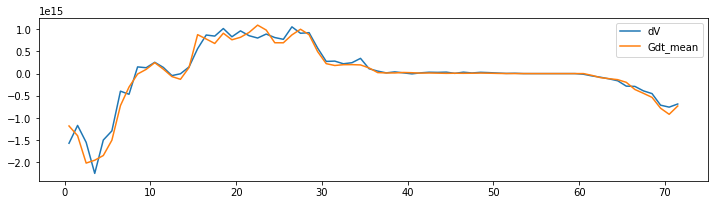

In [21]:
# Volume
c = 2
V=(rho0*h*grid['areacello']).where(l>c).sum(['xh','yh','zl'])
dV = V.diff('time')
days=np.arange(len(V['time']))
days_mean = 0.5*(days[1:]+days[:-1])

# Calculate E_c around this contour
dc = 0.1
layer = (l>c-dc/2) & (l<c+dc/2)
G = ((dheat*grid['areacello']/cp).where(layer).sum(['xh','yh','zl'])/dc).load();
Gdt = G*(dt*1E-9)
# Gdt_mean = Gdt.rolling({'time':2},center=True).mean()
Gdt_mean = 0.5*(Gdt.values[1:]+Gdt.values[:-1]);

# # Calculate forcing terms
# F=((f_c*grid['areacello']).where(ds['temp']>c).sum(['xh','yh','zl'])).load();
# F_mean = 0.5*(F.values[1:]+F.values[:-1]);

fig,ax=plt.subplots(figsize=(12,3))
ax.plot(days_mean,dV,label='dV')
ax.plot(days_mean,Gdt_mean,label='Gdt_mean')
# ax.plot(days_mean,F_mean,label='F')
ax.legend()

In [ ]:
# Volume
c = 4
V=(h*grid['areacello']).where(l>c).sum(['xh','yh','zl'])
dVdt = V.diff('time')/86400
days=np.arange(len(V['time']))
days_mean = 0.5*(days[1:]+days[:-1])

# Calculate E_c around this contour
dc = 0.25
# Calculate it relative to the time mean contour
l_mean = l.rolling({'time':2},center=True).mean()
dheat_mean = 0.5*(dheat[1:,:,:,:].values+dheat[:-1,:,:,:].values)
layer = (l_mean>c-dc/2) & (l_mean<c+dc/2)
G = ((dheat*grid['areacello']/cp/rho0).where(layer).sum(['xh','yh','zl'])/dc).load();
G_mean = 0.5*(G.values[1:]+G.values[:-1]);
G_mean = G.rolling({'time':2},center=True).mean()

# Calculate forcing terms
F=((f_c*grid['areacello']).where(ds['temp']>c).sum(['xh','yh','zl'])).load();
F_mean = 0.5*(F.values[1:]+F.values[:-1]);

fig,ax=plt.subplots(figsize=(12,3))
ax.plot(days_mean,dVdt,label='dVdt')
ax.plot(days_mean,G_mean,label='G')
ax.plot(days_mean,F_mean,label='F')
ax.legend()

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = 

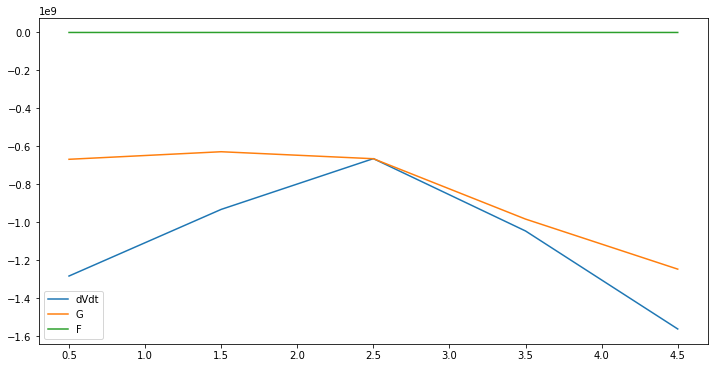

In [40]:
# Coarsen to 5-day means
dt = 5
h_dt = h.coarsen(time=dt,boundary='trim').mean()
l_dt = l.coarsen(time=dt,boundary='trim').mean()
dheat_dt = dheat.coarsen(time=dt,boundary='trim').mean()
f_dt = f_c.coarsen(time=dt,boundary='trim').mean()

# Volume
c = 4
V=(rho0*h_dt*grid['areacello']).where(l_dt>c).sum(['xh','yh','zl'])
dVdt = V.diff('time')/(dt*86400)
days=np.arange(len(V['time']))
days_mean = 0.5*(days[1:]+days[:-1])

# Calculate E_c around this contour
dc = 0.25
layer = (l_dt>c-dc/2) & (l_dt<c+dc/2)
G = ((dheat_dt*grid['areacello']/cp).where(layer).sum(['xh','yh','zl'])/dc).load()
G_mean = 0.5*(G.values[1:]+G.values[:-1])

# Calculate forcing terms
F=((f_dt*grid['areacello']).where(l_dt>c).sum(['xh','yh','zl'])).load()
F_mean = 0.5*(F.values[1:]+F.values[:-1])

fig,ax=plt.subplots(figsize=(12,6))
ax.plot(days_mean,dVdt,label='dVdt')
ax.plot(days_mean,G_mean,label='G')
ax.plot(days_mean,F_mean,label='F')
ax.legend()